## Market Basket Analysis and Association Rules

You have been requested by your Project Manager to identify the associations and combinations between different products (https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset) and implement a Market Basket Analysis for the organization that you work on. This dataset contains information on purchases made at a grocery store of your organization.

<b>Market Basket Analysis</b> is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

<b>Association Rules</b> are widely used to analyze retail basket or transaction data and are intended to identify strong rules discovered in transaction data using measures of interestingness, based on the concept of strong rules.

You have been advised to use the <a href="https://pandas.pydata.org/docs/index.html" target="_blank">pandas</a> and <a href="https://rasbt.github.io/mlxtend/" target="_blank">MLXtend</a> libraries if you have not already.

### Theory of Association Rules

Association rules determines dependencies among different items. It is used for stocking purposes and for placement of items in stores ie. Market Basket Analysis.

Rule form: antecedent --> consequent [support, confidence] & lift eg: Bread --> Milk says if a customer buys bread then high chances that he will buy milk too.

There are 3 factors in considering imp of a rule, which are:

<b>Support</b> = no. of transactions with both antecedent and consequent / no. of total transactions support indicates volume / popularity of an item.

<b>Confidence</b> = no. of transactions with both antecedent and consequent / no. of transactions with antecedent items.

confidence checks binding

Lift = support(overall) / support(antecedent) * support(consequent)
lift checks importance of rule
<ul>
<li>lift > 1 means consequent likely to be bought with x</li>

<li>lift < 1 means consequent unlikely to be bought with x</li>

<li>lift = 1 means no association between x and y</li>
</ul>

In [3]:
# importing necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

#### 1st Task: EDA - Identify products with more sales and order by popularity

In [5]:
df = pd.read_csv('Groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [6]:
df.info()
#In this way, we gain not only an overview of the dataset’s structure but also a deeper understanding of the types of data it contains, which helps guide subsequent analysis steps.
# df.describe() wont make much sense since data are mainly categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


Our dataset contains information on purchases made at a grocery store, including the transaction date, item description, and a unique customer ID. It has two categorical (Date and itemDescription) and one numerical (Member_number) values. This dataframe (df) will be used to perform market basket analysis and identify item combinations that are frequently bought together.

The data consists of three columns:
<ul><li><b>Member_number:</b> A numerical column (integer type) with 38,765 non-null values. This could represent a unique identifier for each member or customer.</li>
<li><b>Date:</b> A column of type object, which likely contains date values (though not yet in a proper datetime format). There are also 38,765 non-null entries, meaning all rows have valid date information.</li>
<li><b>itemDescription:</b> A text column (also 38,765 non-null) containing descriptions of items or products.</li></ul>

In [7]:
df.duplicated().sum() #Though we have duplicate entries, we do not remove them because this is transaction data. 

759

In [8]:
# popularity wise groceries

# Summarize the item counts
item_popularity = df['itemDescription'].value_counts().reset_index()

# Rename columns for clarity
item_popularity.columns = ['itemDescription', 'count']

# Sort by popularity
item_popularity = item_popularity.sort_values(by='count', ascending=False)

# Print the summarized item popularity
print(item_popularity)

           itemDescription  count
0               whole milk   2502
1         other vegetables   1898
2               rolls/buns   1716
3                     soda   1514
4                   yogurt   1334
..                     ...    ...
162        rubbing alcohol      5
163                   bags      4
164         baby cosmetics      3
165        kitchen utensil      1
166  preservation products      1

[167 rows x 2 columns]


More specifically what is implemented in this snippet of code is as per below:
<ul><li>value_counts() is used to count how many times each item appears in the itemDescription column.</li>
<li>The results are then reset into a DataFrame using reset_index() and columns are renamed for clarity.</li>
<li>Finally, the data is sorted by the count to list the most popular items at the top.</li></ul>

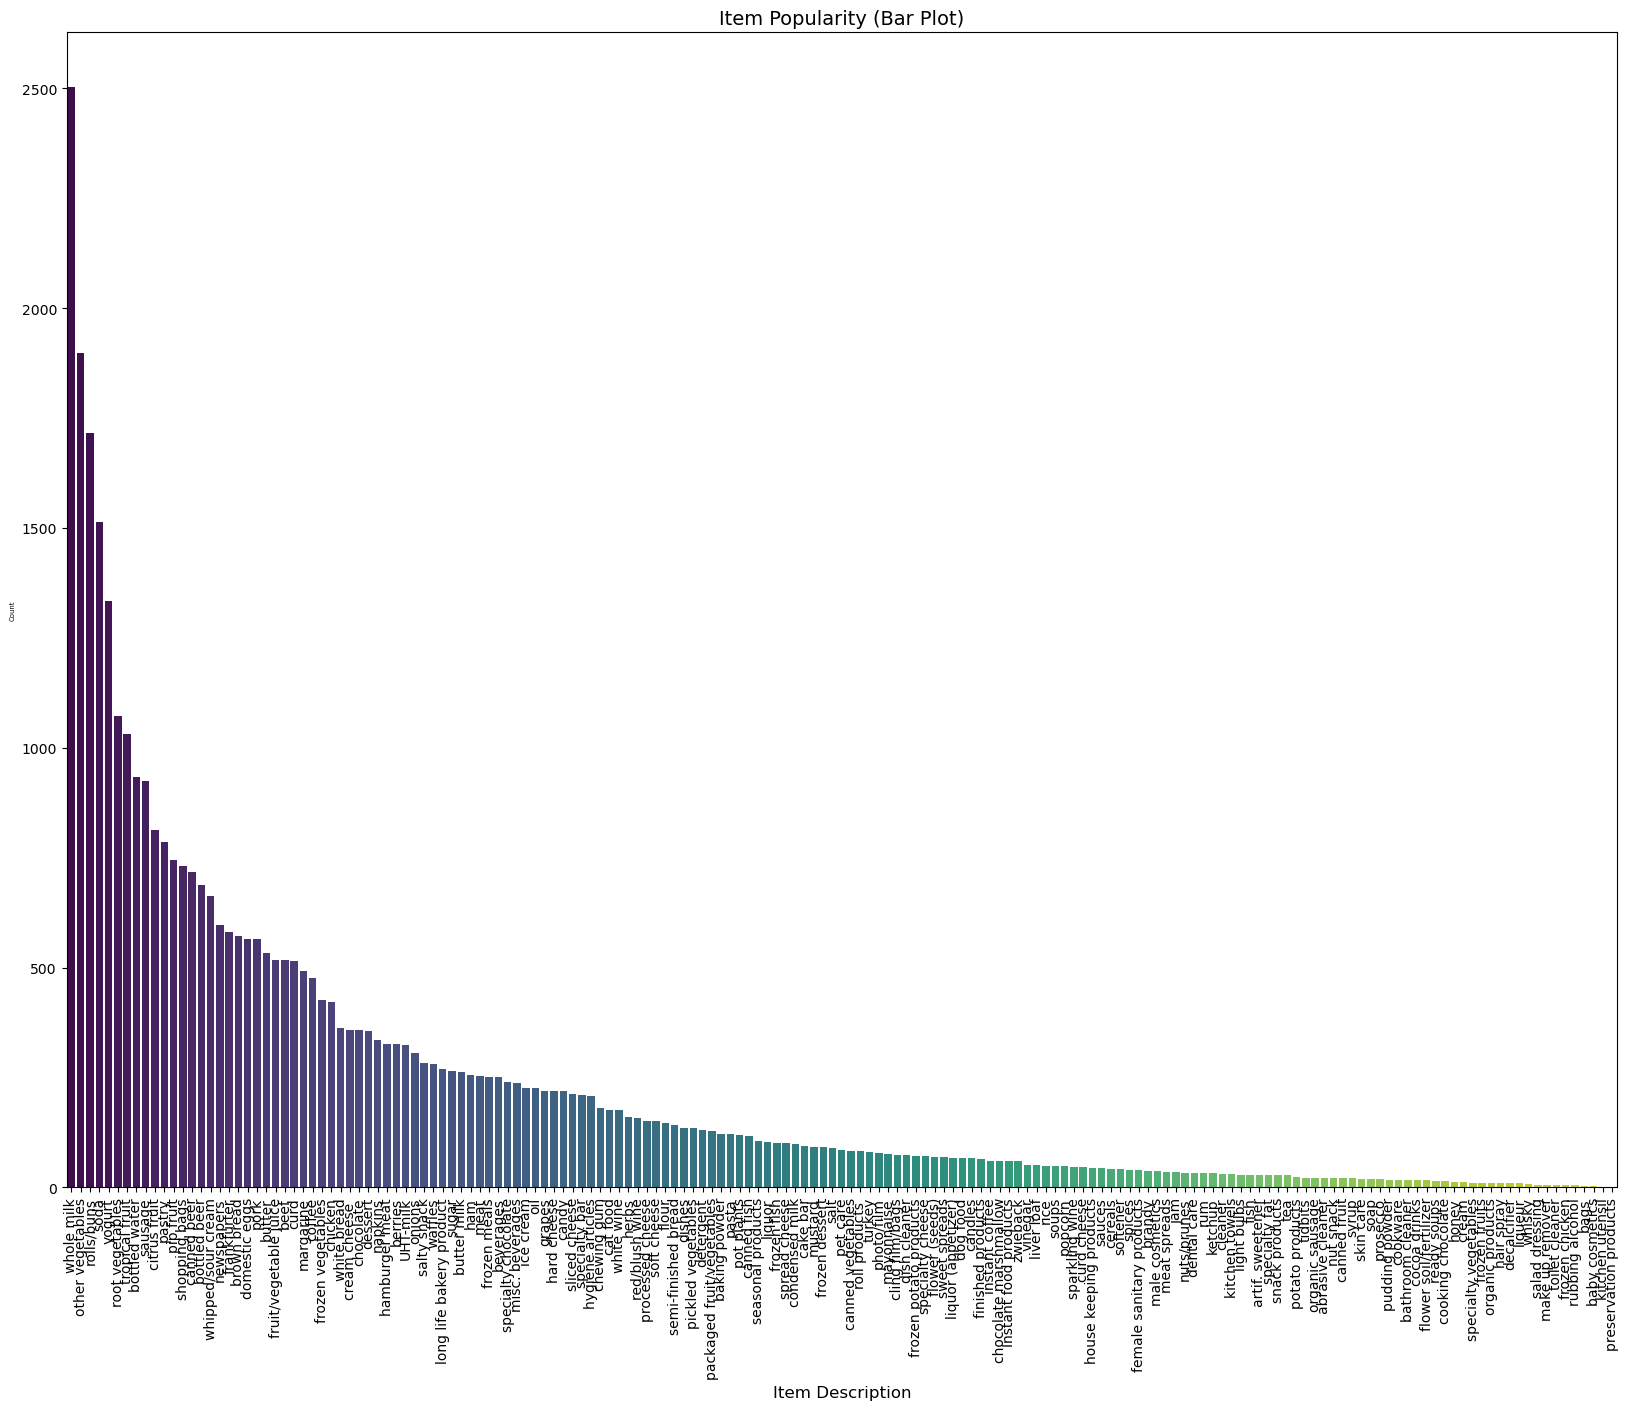

In [9]:
# Bar Plot
plt.figure(figsize=(20, 15))
sns.barplot(x='itemDescription', y='count', data=item_popularity, palette='viridis')
plt.title('Item Popularity (Bar Plot)', fontsize=14)
plt.xlabel('Item Description', fontsize=12)
plt.ylabel('Count', fontsize=5)
plt.xticks(rotation=90)
plt.show()

<b>We choose to use the Bar Plot visualization as it is ideal for identifying the spread and sales (number of times each item appears) for each item</b>
The <b>seaborn.barplot</b> is used to create the bar plot with item descriptions on the x-axis and counts on the y-axis.

#### 2nd Task: Convert this data into a format that can easily be ingested into the Apriori algorithm.Turn it into a tabular structure comprising ones and zeros.

Before we perform market basket analysis, we need to convert these data into a format that can easily be ingested into the Apriori algorithm. In other words, we need to turn it into a tabular structure comprising ones and zeros.

To achieve this, we first must group items that have the same member number and dates

In [10]:
#Write your code to group items that have the same member number and date. Providing a list of products purchased in the same transaction.
#Create a df[‘single_transaction’] variable that combines the member number, and date, and indicates the item purchased in one receipt.
#To achieve this, we first group items that have the same member number and dates

df['single_transaction'] = df['Member_number'].astype(str)+'_'+df['Date'].astype(str)
df.head()

,Member_number,Date,itemDescription,single_transaction
0,1808,21-07-2015,tropical fruit,1808_21-07-2015
1,2552,05-01-2015,whole milk,2552_05-01-2015
2,2300,19-09-2015,pip fruit,2300_19-09-2015
3,1187,12-12-2015,other vegetables,1187_12-12-2015
4,3037,01-02-2015,whole milk,3037_01-02-2015


In [11]:
#Write your code to pivot the produced table to convert the items into columns and the transactions into rows
df2 = pd.crosstab(df['single_transaction'], df['itemDescription'])
df2.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
single_transaction,,,,,,,,,,,,,,,,,,,,,
1000_15-03-2015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1000_24-06-2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1000_24-07-2015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_25-11-2015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000_27-05-2015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The resulting table tells us how many times each item has been purchased in one transaction. 

The final data pre-processing step involves encoding all values in the above data frame to 0 and 1.

This means that even if there are multiples of the same item in the same transaction, the value will be encoded to 1 since market basket analysis does not take purchase frequency into consideration.

In [16]:
#Encode all values in the above created data frame to 0 and 1.
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res
    
basket_input = df2.applymap(encode)

### Build the Apriori Algorithm for Market Basket Analysis

## Apriori Algorithm
First step in generation of association rules is to get all the frequent itemsets on which binary partitions can be performed to get the antecedent and the consequent.

Size of an itemset can vary from one to the total number of items that we have. Now, we seek only frequent itemsets from this and not all, hence we set minimum threshold value.

eg: (Toothpaste, Toothbrush) might not be frequent itemsets if it occurs only 1 in 20 transactions ie 1/20 = 0.05 but our min_support is 0.1 ie 10%

In [17]:
# Write your code for Association rules with 10% support and 20% confidence
frequent_items = apriori(basket_input, min_support=0.1, use_colnames=True)
frequent_items

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.122101,(other vegetables)
1,0.110005,(rolls/buns)
2,0.157923,(whole milk)


The above results indicate that we have received:

<u>Support of <b>0.122101</b> for "other vegetables":</u>
This means that 12.21% of all transactions in the dataset contain other vegetables.
This itemset is frequently bought by customers, appearing in more than 10% of the transactions (meeting the minimum support threshold of 0.1).

<u>Support of <b>0.110005</b> for "rolls/buns":</u>
About 11% of all transactions contain rolls/buns.
This itemset also meets the minimum support threshold and appears frequently.

<u>Support of <b>0.157923</b> for "whole milk":</u>
Whole milk appears in 15.79% of all transactions, making it the most frequent single itemset among those listed.
It is the most popular item from the results, surpassing the minimum support threshold.

In [18]:
# with 20% Confidence
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.20)
rules 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


Based on the above we can understand that by having 10% support and 20% we do not get high numbers of associated products.

Thus, it is wise to decrease for the thresholds for this particular dataset.

In [19]:
# Write your code for Association rules with 0.5% support and 0.5% confidence
frequent_items = apriori(basket_input, min_support=0.005, use_colnames=True)
frequent_items

c:\Users\20202631\AppData\Local\anaconda3v2\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.021386,(UHT-milk)
1,0.008087,(baking powder)
2,0.033950,(beef)
3,0.021787,(berries)
4,0.016574,(beverages)
...,...,...
121,0.011629,"(whole milk, soda)"
122,0.005814,"(yogurt, soda)"
123,0.008220,"(whole milk, tropical fruit)"
124,0.005213,"(yogurt, tropical fruit)"


In [30]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.005)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(bottled beer),0.157923,0.045312,0.007151,0.045281,0.999330,-0.000005,0.999968,-0.000795
1,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874,-0.000702
2,(bottled water),(other vegetables),0.060683,0.122101,0.005480,0.090308,0.739619,-0.001929,0.965051,-0.272617
3,(other vegetables),(bottled water),0.122101,0.060683,0.005480,0.044882,0.739619,-0.001929,0.983457,-0.286230
4,(bottled water),(whole milk),0.060683,0.157923,0.007151,0.117841,0.746196,-0.002432,0.954564,-0.265842


In the above table, the "antecedents" and "consequents" columns show items that are frequently purchased together.

In this example, the first row of the dataset tells us that if a person will buy a whole milk, then they are also likely to purchase bottled beer.

<ul>
<li>Antecedent support variable tells us probability of antecedent products alone</li>
<li>Consequents support variable tells us probability of consequents products alone</li>
<li>The support value is the value of the two products (Antecedents and Consequents)</li>
<li>Confidence is an indication of how often the rule has been found to be true.</li>
<li>The ratio of the observed support to that expected if X and Y were independent.</li>
<li>A leverage value of 0 indicates independence. Range will be [-1 1]</li>
<li>A high conviction value means that the consequent is highly depending on the ante edent and range [0 inf]</li>
</ul>ange [0 inf]

In [32]:
# Order the most frequent item combinations in the entire dataset, by sorting the dataset by support, confidence, and lift
rules_10 = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(10)
rules_10

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
29,(other vegetables),(whole milk),0.122101,0.157923,0.014837,0.121511,0.769430,-0.004446,0.958551,-0.254477
28,(whole milk),(other vegetables),0.157923,0.122101,0.014837,0.093948,0.769430,-0.004446,0.968928,-0.262461
46,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550,-0.214986
47,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350,-0.224474
65,(soda),(whole milk),0.097106,0.157923,0.011629,0.119752,0.758296,-0.003707,0.956636,-0.260917
64,(whole milk),(soda),0.157923,0.097106,0.011629,0.073635,0.758296,-0.003707,0.974663,-0.274587
73,(yogurt),(whole milk),0.085879,0.157923,0.011161,0.129961,0.822940,-0.002401,0.967861,-0.190525
72,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638,-0.203508
18,(rolls/buns),(other vegetables),0.110005,0.122101,0.010559,0.095990,0.786154,-0.002872,0.971117,-0.234091
19,(other vegetables),(rolls/buns),0.122101,0.110005,0.010559,0.086481,0.786154,-0.002872,0.974249,-0.236553


The resulting table shows that the four most popular product combinations that are frequently bought together are:
<ul>
<li>Other vegetables and whole milk</li>
<li>Rolls/buns and whole milk</li>
<li>Soda and whole milk</li>
<li>Yogurt and whole milk</li>
</ul>

One reason for this could be that the grocery store ran a promotion on these items together or displayed them within the same line of sight to improve sales. More explicitly a respective example follows:

<b>Rule 1: (other vegetables) → (whole milk)</b>

<i>Support: 0.014837</i> → 1.48% of all transactions contain both other vegetables and whole milk.

<i>Confidence: 0.121511</i> → Given that someone buys other vegetables, there's a 12.15% chance they also buy whole milk.

<i>Lift: 0.769</i> → The items are negatively correlated, meaning whole milk is less likely to be bought when someone buys other vegetables than if they were independent.

<i>Zhang's Metric:</i> -0.254477 → This negative value also indicates a weak or even negative association between these items.

In [34]:
# Lift Ratio > 1 indicates good influential rule 
rules[(rules.lift>1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
12,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
13,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,0.000536,1.004579,0.118536
54,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613,0.015702
55,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,0.000088,1.000963,0.016341
58,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345,0.104587
59,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049,0.107508


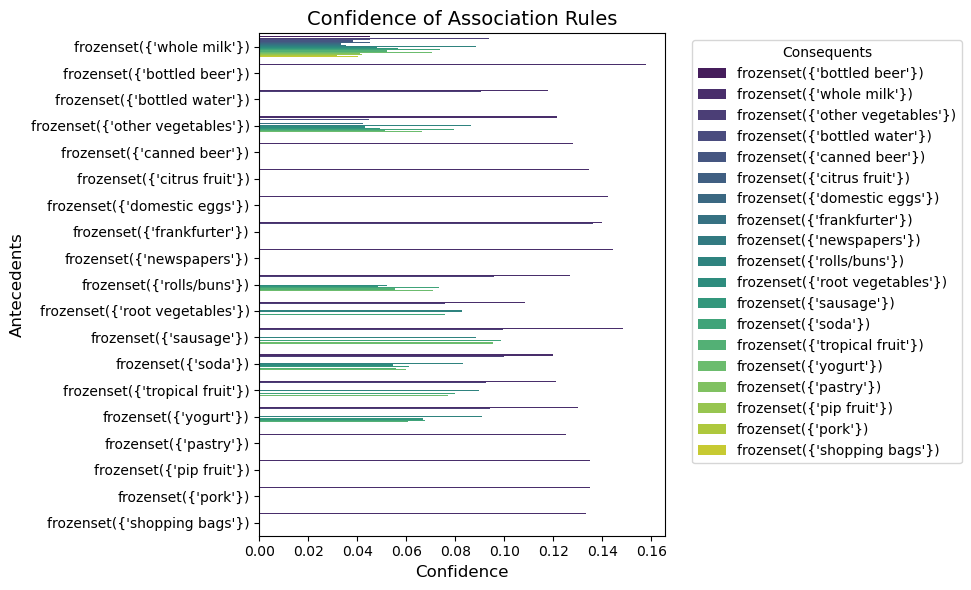

In [35]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents', hue='consequents', data=rules, palette='viridis')

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

C:\Users\20236359\AppData\Local\Temp\ipykernel_18360\634341774.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="support",y="confidence",data=rules, palette='viridis')


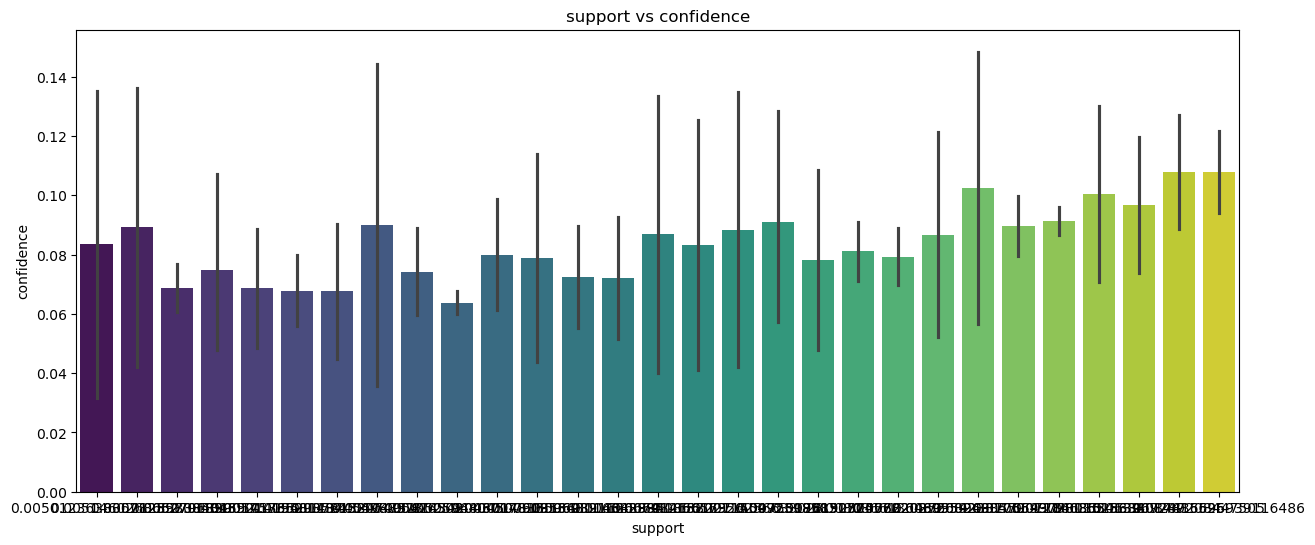

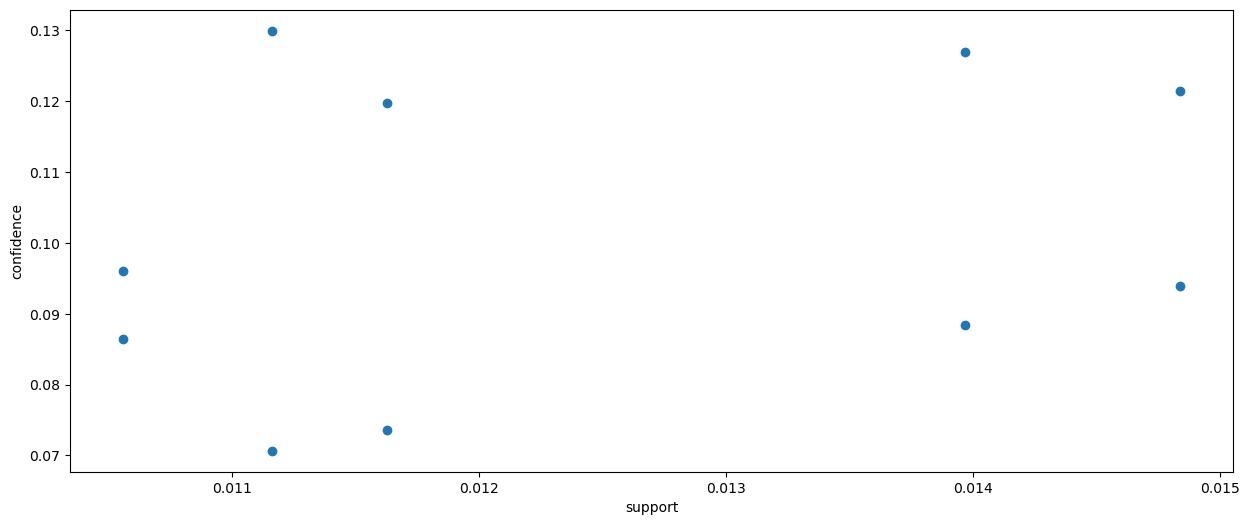

In [36]:
#### Visualization of obtained rules
plt.figure(figsize=(15,6))
sns.barplot(x="support",y="confidence",data=rules, palette='viridis')
plt.title("support vs confidence")
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(rules_10['support'],rules_10['confidence'])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

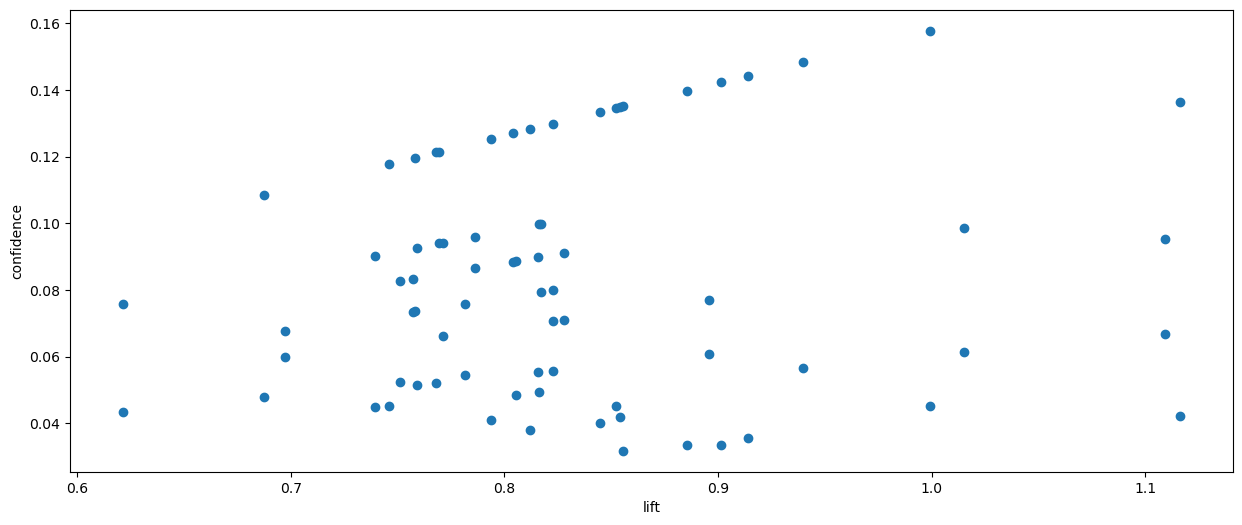

In [37]:
plt.figure(figsize=(15,6))
plt.scatter(rules['lift'],rules['confidence'])
plt.xlabel('lift')
plt.ylabel('confidence') 
plt.show()

In [38]:
# Write your code for Association rules with 15% Support and 30% confidence
frequent_items = apriori(basket_input, min_support=0.15, use_colnames=True)
frequent_items

C:\Users\20236359\AppData\Local\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.157923,(whole milk)


In [39]:
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.30)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


The latter clearly indicates the low interpretability and association between the different examined products. This is supported by the wide range of products and items that are used in this specific dataset. The decreasing of the thresholds will showcase a better association and linkage between the different products.